In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torchvision import transforms
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.feature_extraction import get_graph_node_names

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.6 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(mask_dir))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        
        # Read original-sized data
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Failed to read image at {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise ValueError(f"Failed to read mask at {mask_path}")
        mask = (mask > 127).astype(np.uint8)
        
        # Let Albumentations handle resizing
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].float()
            
            # Ensure mask has channel dimension
            if mask.dim() == 2:
                mask = mask.unsqueeze(0)  # Add channel dim
            elif mask.dim() == 3 and mask.shape[0] != 1:
                mask = mask.permute(2, 0, 1).unsqueeze(0)
                
        return image, mask
class StructureLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    
    def forward(self, pred, mask):
        # Fix mask dimensions (NEW CODE)
        if mask.dim() == 3:  # [B,H,W] format
            mask = mask.unsqueeze(1)  # Add channel dimension -> [B,1,H,W]
        
        # Fix prediction dimensions
        if pred.dim() == 3:  # Handle single-channel predictions
            pred = pred.unsqueeze(1)

        pred = F.interpolate(pred, mask.shape[-2:], mode='bilinear', align_corners=True)
        weit = 1 + 5*torch.abs(F.avg_pool2d(mask, 31, 1, 15) - mask)
        bce = (weit * self.bce(pred, mask)).sum(dim=(2,3)) / weit.sum(dim=(2,3))
        
        pred = torch.sigmoid(pred)
        inter = (pred * mask).sum(dim=(2,3))
        union = (pred + mask).sum(dim=(2,3))
        iou = 1 - (inter + 1)/(union - inter + 1)
        
        return (bce + iou).mean()




In [6]:
class ReverseAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv_high = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU()
        )
        self.conv_low = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x_high, x_low):
        if x_high.size()[-2:] != x_low.size()[-2:]:
            x_high = F.interpolate(x_high, size=x_low.shape[-2:], mode='bilinear', align_corners=True)
        attention = 1 - self.conv_low(x_low)
        return self.conv_high(x_high) * attention + x_low


class RaBiT(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        # Original ViT backbone with pretrained weights
        self.vit = torchvision.models.vit_b_16(weights='DEFAULT')
        
        # Freeze ViT weights
        for param in self.vit.parameters():
            param.requires_grad = False

        # Use correct node names based on the actual ViT architecture
        self.feature_extractor = create_feature_extractor(
        self.vit,
        return_nodes={
            'encoder.layers.encoder_layer_3.add_1': 'z3',
            'encoder.layers.encoder_layer_6.add_1': 'z6', 
            'encoder.layers.encoder_layer_9.add_1': 'z9',
            'encoder.layers.encoder_layer_11.add_1': 'z12'
        }
    )
        
        # Feature adapters with spatial alignment
        self.adapters = nn.ModuleDict({
            'z3': nn.Sequential(
                nn.Conv2d(768, 64, 1),
                nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
            ),
            'z6': nn.Sequential(
                nn.Conv2d(768, 64, 1),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            ),
            'z9': nn.Conv2d(768, 64, 1),
            'z12': nn.Sequential(
                nn.Conv2d(768, 64, 1),
                nn.MaxPool2d(2)
            )
        })
        
        # RaBiT processing blocks
        self.ra_blocks = nn.ModuleList([ReverseAttention(64) for _ in range(9)])
        self.pred_convs = nn.ModuleList([
            nn.Conv2d(64, num_classes, 1) for _ in range(4)
        ])
        self.upsample = nn.Upsample(scale_factor=16, mode='bilinear', align_corners=True)

    def _process_vit_features(self, features):
        """Convert ViT sequence features to spatial tensors"""
        processed = {}
        for key, feat in features.items():
            # Remove class token [batch, 197, 768] -> [batch, 196, 768]
            patch_feat = feat[:, 1:] 
            # Reshape to 2D grid [batch, 196, 768] -> [batch, 14, 14, 768]
            batch_size = patch_feat.size(0)
            patch_feat = patch_feat.reshape(batch_size, 14, 14, 768)
            # Permute to [batch, 768, 14, 14]
            processed[key] = patch_feat.permute(0, 3, 1, 2)
        return processed

    def forward(self, x):
        # Extract features using ViT backbone (no need to resize here as ViT handles it)
        features = self.feature_extractor(x)
        features = self._process_vit_features(features)
        
        # Process through adapters
        z3 = self.adapters['z3'](features['z3'])
        z6 = self.adapters['z6'](features['z6'])
        z9 = self.adapters['z9'](features['z9'])
        z12 = self.adapters['z12'](features['z12'])
        
        # RaBiT processing stages
        f2 = self.ra_blocks[0](z3, z6)
        f3 = self.ra_blocks[1](z3, z9)
        f4 = self.ra_blocks[2](z3, z12)
        
        f23 = self.ra_blocks[3](f2, f3)
        f34 = self.ra_blocks[4](f3, f4)
        f234 = self.ra_blocks[5](f23, f34)
        
        up1 = F.interpolate(z3, scale_factor=2, mode='bilinear', align_corners=True)
        up2 = F.interpolate(f234, scale_factor=2, mode='bilinear', align_corners=True)
        
        up1 = self.ra_blocks[6](up1, up1)
        up2 = self.ra_blocks[7](up2, up2)
        combined = self.ra_blocks[8](up1, up2)
        
        # Generate multi-scale predictions
        preds = [
            self.pred_convs[0](z3),
            self.pred_convs[1](f234),
            self.pred_convs[2](up1),
            self.pred_convs[3](combined)
        ]
        
        return [self.upsample(p) for p in preds]

In [49]:

def train_rabit_model():
    # First, check the correct node names for the ViT model
    vit_model = torchvision.models.vit_b_16(weights='DEFAULT')
    train_nodes, eval_nodes = get_graph_node_names(vit_model)
    
    # Print ALL available layer names to find appropriate substitutes
    print("Available node names for ViT model:")
    layer_nodes = [node for node in eval_nodes if 'encoder.layers' in node]
    for node in layer_nodes:  # Show all layer nodes
        print(node)
    
    # Initialize dataset
    train_transform = A.Compose([
    A.Resize(480, 480),
    A.HorizontalFlip(p=0.4),
    A.VerticalFlip(p=0.4),
    A.RandomGamma(gamma_limit=(70, 130), p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(transpose_mask=True),  # Critical fix for mask dimensions
], is_check_shapes=False)
    

    
    train_dataset = CustomDataset(
        img_dir="/kaggle/input/datacv/drive-download-20250407T081859Z-001/TrainDataset/TrainDataset/image",
        mask_dir="/kaggle/input/datacv/drive-download-20250407T081859Z-001/TrainDataset/TrainDataset/mask",
        transform=train_transform
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=8,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        drop_last=True
    )
    
    # Model setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = RaBiT().to(device)
    
    # Loss and optimizer
    criterion = StructureLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler()
    
    # Training loop
    best_loss = float('inf')  # Initialize best loss

    for epoch in range(500):
        model.train()
        epoch_loss = 0.0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            images = images.to(device).float()
            masks = masks.to(device).float()

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(images)
                #loss = sum(0.25 * criterion(p, masks) for p in outputs)
                loss = criterion(outputs[-1], masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

        # Save only if this is the best model so far
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), "rabit_best.pth")
            print(f"Saved new best model at epoch {epoch+1} with loss {best_loss:.4f}")


train_rabit_model()

Available node names for ViT model:
encoder.layers.encoder_layer_0.dim
encoder.layers.encoder_layer_0.eq
encoder.layers.encoder_layer_0.getattr
encoder.layers.encoder_layer_0._assert
encoder.layers.encoder_layer_0.ln
encoder.layers.encoder_layer_0.self_attention
encoder.layers.encoder_layer_0.getitem
encoder.layers.encoder_layer_0.getitem_1
encoder.layers.encoder_layer_0.dropout
encoder.layers.encoder_layer_0.add
encoder.layers.encoder_layer_0.ln_1
encoder.layers.encoder_layer_0.mlp
encoder.layers.encoder_layer_0.add_1
encoder.layers.encoder_layer_1.dim
encoder.layers.encoder_layer_1.eq
encoder.layers.encoder_layer_1.getattr
encoder.layers.encoder_layer_1._assert
encoder.layers.encoder_layer_1.ln
encoder.layers.encoder_layer_1.self_attention
encoder.layers.encoder_layer_1.getitem
encoder.layers.encoder_layer_1.getitem_1
encoder.layers.encoder_layer_1.dropout
encoder.layers.encoder_layer_1.add
encoder.layers.encoder_layer_1.ln_1
encoder.layers.encoder_layer_1.mlp
encoder.layers.encoder_

<ipython-input-49-0eff3fc189f2>:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/100:   0%|          | 0/362 [00:00<?, ?it/s]<ipython-input-49-0eff3fc189f2>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/100: 100%|██████████| 362/362 [00:29<00:00, 12.32it/s]


Epoch 1 Loss: 0.9450
Saved new best model at epoch 1 with loss 0.9450


Epoch 2/100: 100%|██████████| 362/362 [00:29<00:00, 12.34it/s]


Epoch 2 Loss: 0.7715
Saved new best model at epoch 2 with loss 0.7715


Epoch 3/100: 100%|██████████| 362/362 [00:29<00:00, 12.24it/s]


Epoch 3 Loss: 0.7195
Saved new best model at epoch 3 with loss 0.7195


Epoch 4/100: 100%|██████████| 362/362 [00:29<00:00, 12.26it/s]


Epoch 4 Loss: 0.6928
Saved new best model at epoch 4 with loss 0.6928


Epoch 5/100: 100%|██████████| 362/362 [00:29<00:00, 12.24it/s]


Epoch 5 Loss: 0.6709
Saved new best model at epoch 5 with loss 0.6709


Epoch 6/100: 100%|██████████| 362/362 [00:29<00:00, 12.21it/s]


Epoch 6 Loss: 0.6544
Saved new best model at epoch 6 with loss 0.6544


Epoch 7/100: 100%|██████████| 362/362 [00:29<00:00, 12.23it/s]


Epoch 7 Loss: 0.6398
Saved new best model at epoch 7 with loss 0.6398


Epoch 8/100: 100%|██████████| 362/362 [00:29<00:00, 12.21it/s]


Epoch 8 Loss: 0.6250
Saved new best model at epoch 8 with loss 0.6250


Epoch 9/100: 100%|██████████| 362/362 [00:29<00:00, 12.22it/s]


Epoch 9 Loss: 0.6146
Saved new best model at epoch 9 with loss 0.6146


Epoch 10/100: 100%|██████████| 362/362 [00:29<00:00, 12.24it/s]


Epoch 10 Loss: 0.6045
Saved new best model at epoch 10 with loss 0.6045


Epoch 11/100: 100%|██████████| 362/362 [00:29<00:00, 12.22it/s]


Epoch 11 Loss: 0.5953
Saved new best model at epoch 11 with loss 0.5953


Epoch 12/100: 100%|██████████| 362/362 [00:29<00:00, 12.23it/s]


Epoch 12 Loss: 0.5884
Saved new best model at epoch 12 with loss 0.5884


Epoch 13/100: 100%|██████████| 362/362 [00:29<00:00, 12.23it/s]


Epoch 13 Loss: 0.5812
Saved new best model at epoch 13 with loss 0.5812


Epoch 14/100: 100%|██████████| 362/362 [00:29<00:00, 12.24it/s]


Epoch 14 Loss: 0.5736
Saved new best model at epoch 14 with loss 0.5736


Epoch 15/100: 100%|██████████| 362/362 [00:29<00:00, 12.21it/s]


Epoch 15 Loss: 0.5685
Saved new best model at epoch 15 with loss 0.5685


Epoch 16/100: 100%|██████████| 362/362 [00:29<00:00, 12.23it/s]


Epoch 16 Loss: 0.5604
Saved new best model at epoch 16 with loss 0.5604


Epoch 17/100: 100%|██████████| 362/362 [00:29<00:00, 12.20it/s]


Epoch 17 Loss: 0.5609


Epoch 18/100: 100%|██████████| 362/362 [00:29<00:00, 12.23it/s]


Epoch 18 Loss: 0.5508
Saved new best model at epoch 18 with loss 0.5508


Epoch 19/100: 100%|██████████| 362/362 [00:29<00:00, 12.23it/s]


Epoch 19 Loss: 0.5476
Saved new best model at epoch 19 with loss 0.5476


Epoch 20/100: 100%|██████████| 362/362 [00:29<00:00, 12.21it/s]


Epoch 20 Loss: 0.5417
Saved new best model at epoch 20 with loss 0.5417


Epoch 21/100: 100%|██████████| 362/362 [00:29<00:00, 12.23it/s]


Epoch 21 Loss: 0.5406
Saved new best model at epoch 21 with loss 0.5406


Epoch 22/100: 100%|██████████| 362/362 [00:29<00:00, 12.24it/s]


Epoch 22 Loss: 0.5332
Saved new best model at epoch 22 with loss 0.5332


Epoch 23/100: 100%|██████████| 362/362 [00:29<00:00, 12.24it/s]


Epoch 23 Loss: 0.5274
Saved new best model at epoch 23 with loss 0.5274


Epoch 24/100: 100%|██████████| 362/362 [00:29<00:00, 12.22it/s]


Epoch 24 Loss: 0.5263
Saved new best model at epoch 24 with loss 0.5263


Epoch 25/100: 100%|██████████| 362/362 [00:29<00:00, 12.24it/s]


Epoch 25 Loss: 0.5206
Saved new best model at epoch 25 with loss 0.5206


Epoch 26/100: 100%|██████████| 362/362 [00:29<00:00, 12.24it/s]


Epoch 26 Loss: 0.5168
Saved new best model at epoch 26 with loss 0.5168


Epoch 27/100: 100%|██████████| 362/362 [00:29<00:00, 12.24it/s]


Epoch 27 Loss: 0.5137
Saved new best model at epoch 27 with loss 0.5137


Epoch 28/100: 100%|██████████| 362/362 [00:29<00:00, 12.22it/s]


Epoch 28 Loss: 0.5127
Saved new best model at epoch 28 with loss 0.5127


Epoch 29/100: 100%|██████████| 362/362 [00:29<00:00, 12.23it/s]


Epoch 29 Loss: 0.5064
Saved new best model at epoch 29 with loss 0.5064


Epoch 30/100: 100%|██████████| 362/362 [00:29<00:00, 12.22it/s]


Epoch 30 Loss: 0.5074


Epoch 31/100: 100%|██████████| 362/362 [00:29<00:00, 12.22it/s]


Epoch 31 Loss: 0.5015
Saved new best model at epoch 31 with loss 0.5015


Epoch 32/100: 100%|██████████| 362/362 [00:29<00:00, 12.23it/s]


Epoch 32 Loss: 0.5002
Saved new best model at epoch 32 with loss 0.5002


Epoch 33/100: 100%|██████████| 362/362 [00:29<00:00, 12.23it/s]


Epoch 33 Loss: 0.4966
Saved new best model at epoch 33 with loss 0.4966


Epoch 34/100: 100%|██████████| 362/362 [00:29<00:00, 12.23it/s]


Epoch 34 Loss: 0.4968


Epoch 35/100: 100%|██████████| 362/362 [00:29<00:00, 12.23it/s]


Epoch 35 Loss: 0.4898
Saved new best model at epoch 35 with loss 0.4898


Epoch 36/100: 100%|██████████| 362/362 [00:29<00:00, 12.21it/s]


Epoch 36 Loss: 0.4879
Saved new best model at epoch 36 with loss 0.4879


Epoch 37/100: 100%|██████████| 362/362 [00:29<00:00, 12.23it/s]


Epoch 37 Loss: 0.4876
Saved new best model at epoch 37 with loss 0.4876


Epoch 38/100: 100%|██████████| 362/362 [00:29<00:00, 12.18it/s]


Epoch 38 Loss: 0.4850
Saved new best model at epoch 38 with loss 0.4850


Epoch 39/100: 100%|██████████| 362/362 [00:29<00:00, 12.23it/s]


Epoch 39 Loss: 0.4800
Saved new best model at epoch 39 with loss 0.4800


Epoch 40/100: 100%|██████████| 362/362 [00:29<00:00, 12.21it/s]


Epoch 40 Loss: 0.4788
Saved new best model at epoch 40 with loss 0.4788


Epoch 41/100: 100%|██████████| 362/362 [00:29<00:00, 12.22it/s]


Epoch 41 Loss: 0.4765
Saved new best model at epoch 41 with loss 0.4765


Epoch 42/100: 100%|██████████| 362/362 [00:29<00:00, 12.22it/s]


Epoch 42 Loss: 0.4776


Epoch 43/100: 100%|██████████| 362/362 [00:29<00:00, 12.22it/s]


Epoch 43 Loss: 0.4780


Epoch 44/100: 100%|██████████| 362/362 [00:29<00:00, 12.20it/s]


Epoch 44 Loss: 0.4711
Saved new best model at epoch 44 with loss 0.4711


Epoch 45/100: 100%|██████████| 362/362 [00:29<00:00, 12.21it/s]


Epoch 45 Loss: 0.4716


Epoch 46/100: 100%|██████████| 362/362 [00:29<00:00, 12.21it/s]


Epoch 46 Loss: 0.4690
Saved new best model at epoch 46 with loss 0.4690


Epoch 47/100: 100%|██████████| 362/362 [00:29<00:00, 12.21it/s]


Epoch 47 Loss: 0.4658
Saved new best model at epoch 47 with loss 0.4658


Epoch 48/100: 100%|██████████| 362/362 [00:29<00:00, 12.21it/s]


Epoch 48 Loss: 0.4618
Saved new best model at epoch 48 with loss 0.4618


Epoch 49/100: 100%|██████████| 362/362 [00:29<00:00, 12.21it/s]


Epoch 49 Loss: 0.4621


Epoch 50/100: 100%|██████████| 362/362 [00:29<00:00, 12.23it/s]


Epoch 50 Loss: 0.4618
Saved new best model at epoch 50 with loss 0.4618


<ipython-input-8-1303a5454d34>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/rabit_best/pytorch/default/1/rabit_best.pth"

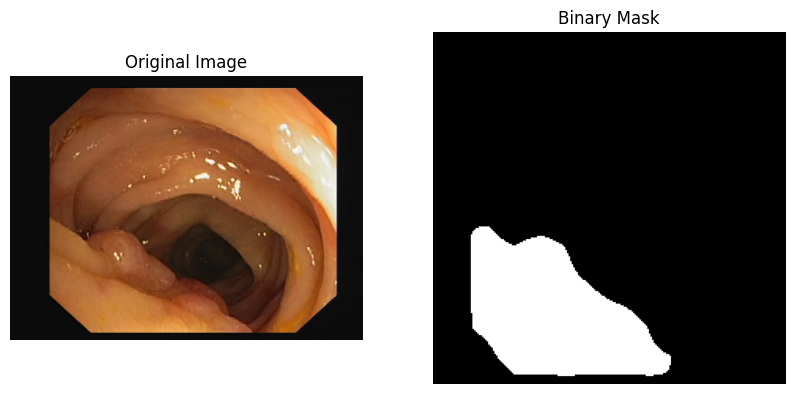

In [8]:
def infer(model, image_path, device):   
    model.eval()
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Change resize from 320x320 to 224x224 to match ViT's expected input size
    transformed = A.Compose([
        A.Resize(224, 224),  # Changed from 320x320 to 224x224
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])(image=image)
    
    input_tensor = transformed['image'].unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        if isinstance(output, (list, tuple)):
            output = output[-1]  # Take the last prediction (typically the best one)
        output = torch.sigmoid(output)
        prediction = (output > 0.5).float().squeeze().cpu().numpy()

    binary_mask = (prediction * 255).astype(np.uint8)  # 0 for background, 255 for object

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(binary_mask, cmap="gray")
    plt.title("Binary Mask")
    plt.axis("off")
    plt.show()
model = RaBiT().to('cuda')  # Move model to GPU FIRST
model.load_state_dict(torch.load("/kaggle/input/rabit_best/pytorch/default/1/rabit_best.pth", map_location='cuda'))
infer(model, "/kaggle/input/datacv/drive-download-20250407T081859Z-001/TrainDataset/TrainDataset/image/1.png", 'cuda')

In [13]:
import torch
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from tqdm import tqdm
import os
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define transforms
val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
    A.Resize(height=224, width=224, p=1),
    ToTensorV2(),
])

# List of dataset subfolders
dataset_names = ['CVC-300', 'CVC-ClinicDB', 'CVC-ColonDB', 'ETIS-LaribPolypDB', 'Kvasir']
base_path = '/kaggle/input/datacv/drive-download-20250407T081859Z-001/TestDataset/TestDataset'

# Collect all datasets
all_datasets = []
for name in dataset_names:
    img_dir = os.path.join(base_path, name, 'images')
    mask_dir = os.path.join(base_path, name, 'masks')
    ds = CustomDataset(img_dir=img_dir, mask_dir=mask_dir, transform=val_transform)
    all_datasets.append(ds)

# Combine datasets
full_test_dataset = ConcatDataset(all_datasets)
test_loader = DataLoader(full_test_dataset, batch_size=1, shuffle=False)

# Load model
model = RaBiT()
model.load_state_dict(torch.load("/kaggle/input/rabit_best/pytorch/default/1/rabit_best.pth", 
                                 map_location='cuda' if torch.cuda.is_available() else 'cpu'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Metrics
def compute_iou(pred, mask, eps=1e-6):
    pred = (pred > 0.5).float()
    mask = (mask > 0.5).float()
    intersection = (pred * mask).sum()
    union = pred.sum() + mask.sum() - intersection
    return (intersection + eps) / (union + eps)

def compute_dice(pred, mask, eps=1e-6):
    pred = (pred > 0.5).float()
    mask = (mask > 0.5).float()
    intersection = (pred * mask).sum()
    return (2 * intersection + eps) / (pred.sum() + mask.sum() + eps)

# Run evaluation
ious, dices = [], []
with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Evaluating all datasets"):
        images = images.to(device)
        masks = masks.to(device).float()
        
        # Get model outputs
        outputs = model(images)
        
        # Fix: Handle the list output from RaBiT model
        # If outputs is a list, take the last element (usually the final prediction)
        if isinstance(outputs, list):
            pred = outputs[-1]  # Take the final output if it's a list of outputs
        else:
            pred = outputs
            
        # Apply sigmoid activation
        probs = torch.sigmoid(pred)
        
        for pred_mask, true_mask in zip(probs, masks):
            iou = compute_iou(pred_mask, true_mask)
            dice = compute_dice(pred_mask, true_mask)
            ious.append(iou.item())
            dices.append(dice.item())

# Per-dataset evaluation
dataset_results = {}
start_idx = 0
for i, ds in enumerate(all_datasets):
    end_idx = start_idx + len(ds)
    ds_ious = ious[start_idx:end_idx]
    ds_dices = dices[start_idx:end_idx]
    
    dataset_results[dataset_names[i]] = {
        'IoU': np.mean(ds_ious),
        'Dice': np.mean(ds_dices)
    }
    
    print(f"📊 {dataset_names[i]}:")
    print(f"   IoU: {np.mean(ds_ious):.4f}")
    print(f"   Dice: {np.mean(ds_dices):.4f}")
    
    start_idx = end_idx

# Final results
macro_iou = np.mean(ious)
macro_dice = np.mean(dices)
print(f"\n📊 Macro IoU (All datasets): {macro_iou:.4f}")
print(f"📊 Macro Dice (All datasets): {macro_dice:.4f}")

<ipython-input-13-252b1d12a803>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/rabit_best/pytorch/default/1/rabit_best.pth

📊 CVC-300:
   IoU: 0.7590
   Dice: 0.8487
📊 CVC-ClinicDB:
   IoU: 0.7569
   Dice: 0.8291
📊 CVC-ColonDB:
   IoU: 0.5773
   Dice: 0.6679
📊 ETIS-LaribPolypDB:
   IoU: 0.4468
   Dice: 0.5328
📊 Kvasir:
   IoU: 0.7692
   Dice: 0.8398

📊 Macro IoU (All datasets): 0.5969
📊 Macro Dice (All datasets): 0.6824
